In [18]:
import sys; sys.path.append('../')
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as tf
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
from python.deepgen.training import adversarial, loss
from python.deepgen.models import periodic
from python.deepgen.datasets import common, dtd, theaven
from python.deepgen.utils.init import Initializer
from python.deepgen.utils.image import Unnormalize

In [20]:
init_map = {
    nn.Conv2d: {'weight': (nn.init.normal_, {'mean': 0.0, 'std': 0.02}),
                'bias': (nn.init.constant_, {'val': 0.0})},
    nn.ConvTranspose2d: {'weight': (nn.init.normal_, {'mean': 0.0, 'std': 0.02}),
                         'bias': (nn.init.constant_, {'val': 0.0})},
}

init_fn = Initializer(init_map)

def build_model(latent_channels, image_channels, hidden_layers, lr):
    model = periodic.vanilla_psgan(latent_channels, image_channels,
                                   hidden_layers, init_fn=init_fn)
    model['gen'].to(device)
    model['disc'].to(device)
    gen_opt = optim.Adam(model['gen'].parameters(), lr=lr, betas=(0.5, 0.999))
    disc_opt = optim.Adam(model['disc'].parameters(),
                          lr=lr, betas=(0.5, 0.999))
    optims = {'gen': gen_opt, 'disc': disc_opt}
    return model, optims


# Single Image (DTD-Honeycombed)

In [21]:
latent_channels = (10, 1, 2)
image_channels = 3
hidden_layers = 3
lr = 2e-4

tensor([1., 1., 1.]) tensor([1., 1., 1.])
Crop Size: torch.Size([129, 129])


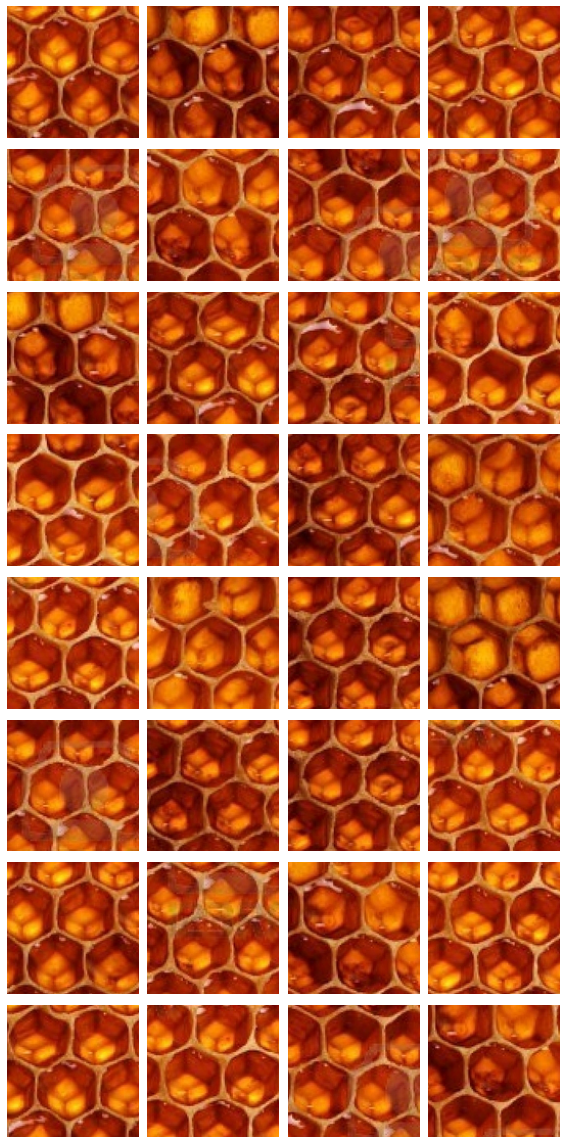

In [22]:
latent_spatial_shape = (5, 5)
model, _ = build_model(latent_channels, image_channels, hidden_layers, lr)

image_path = '../data/dtd/images/honeycombed/honeycombed_0003.jpg'
tensor_image = tf.ToTensor()(Image.open(image_path))
mean, std = tensor_image.mean((1, 2)), tensor_image.std((1, 2))


# mean = torch.tensor([0.5, 0.5, 0.5])
# std = torch.tensor([0.5, 0.5, 0.5])

mean = torch.tensor([1.0, 1.0, 1.0])
std = torch.tensor([1.0, 1.0, 1.0])
print(mean, std)

crop_size = model['gen'](torch.zeros(1, latent_channels[1], *latent_spatial_shape, device=device)).shape[-2:]
iterations = 2000
batch_size = 32
shuffle=False
num_workers=8
transfrom = tf.Compose([
    tf.RandomCrop(crop_size),
    tf.ToTensor(),
    tf.Normalize(mean=mean, std=std)])

dataset = common.SingleImageDataset(
    image_path, iterations, transform=transfrom)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size,
    shuffle, num_workers=num_workers
)

output_transform = tf.Compose([
    Unnormalize(mean, std),
    tf.Lambda(lambda x: x.squeeze(0)),
    tf.ToPILImage('RGB')
])

samples = torch.split(next(iter(dataloader)), 1)

num_cols = 4
num_rows = int(np.ceil(batch_size/num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
for ax, sample in zip(itertools.chain.from_iterable(axes), samples):
    ax.imshow(output_transform(sample))
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()

print('Crop Size:', crop_size)


## BCELoss

In [23]:
model, optims = build_model(latent_channels, image_channels, hidden_layers, lr)
criterions = [nn.BCEWithLogitsLoss(reduction='mean')]
samplers = {
    'latent': lambda bs: torch.zeros(bs, latent_channels[1], *latent_spatial_shape),
    'labels': lambda bs: (torch.ones(bs, 1, *latent_spatial_shape),
                          torch.zeros(bs, 1, *latent_spatial_shape))
}
trainer = adversarial.Trainer(model, optims, samplers, criterions, device)

num_epochs = 32
output_dir = os.path.join('../models/vanilla_psgan_hcomb_bce')

epoch: 1; gen:   2.204212; disc:   1.083473; disc_real(BCEWithLogitsLoss):   0.864610; disc_fake(BCEWithLogitsLoss):   0.218863; gen_partial(BCEWithLogitsLoss):   2.204212: 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]
epoch: 2; gen:   6.178210; disc:   0.057803; disc_real(BCEWithLogitsLoss):   0.030528; disc_fake(BCEWithLogitsLoss):   0.027275; gen_partial(BCEWithLogitsLoss):   6.178210: 100%|██████████| 63/63 [00:11<00:00,  5.65it/s]
epoch: 3; gen:   3.305175; disc:   0.165403; disc_real(BCEWithLogitsLoss):   0.134529; disc_fake(BCEWithLogitsLoss):   0.030873; gen_partial(BCEWithLogitsLoss):   3.305175: 100%|██████████| 63/63 [00:11<00:00,  5.65it/s]
epoch: 4; gen:   5.016405; disc:   0.037506; disc_real(BCEWithLogitsLoss):   0.024734; disc_fake(BCEWithLogitsLoss):   0.012772; gen_partial(BCEWithLogitsLoss):   5.016405: 100%|██████████| 63/63 [00:11<00:00,  5.68it/s]
epoch: 5; gen:   3.676503; disc:   0.304823; disc_real(BCEWithLogitsLoss):   0.058949; disc_fake(BCEWithLogitsLoss):

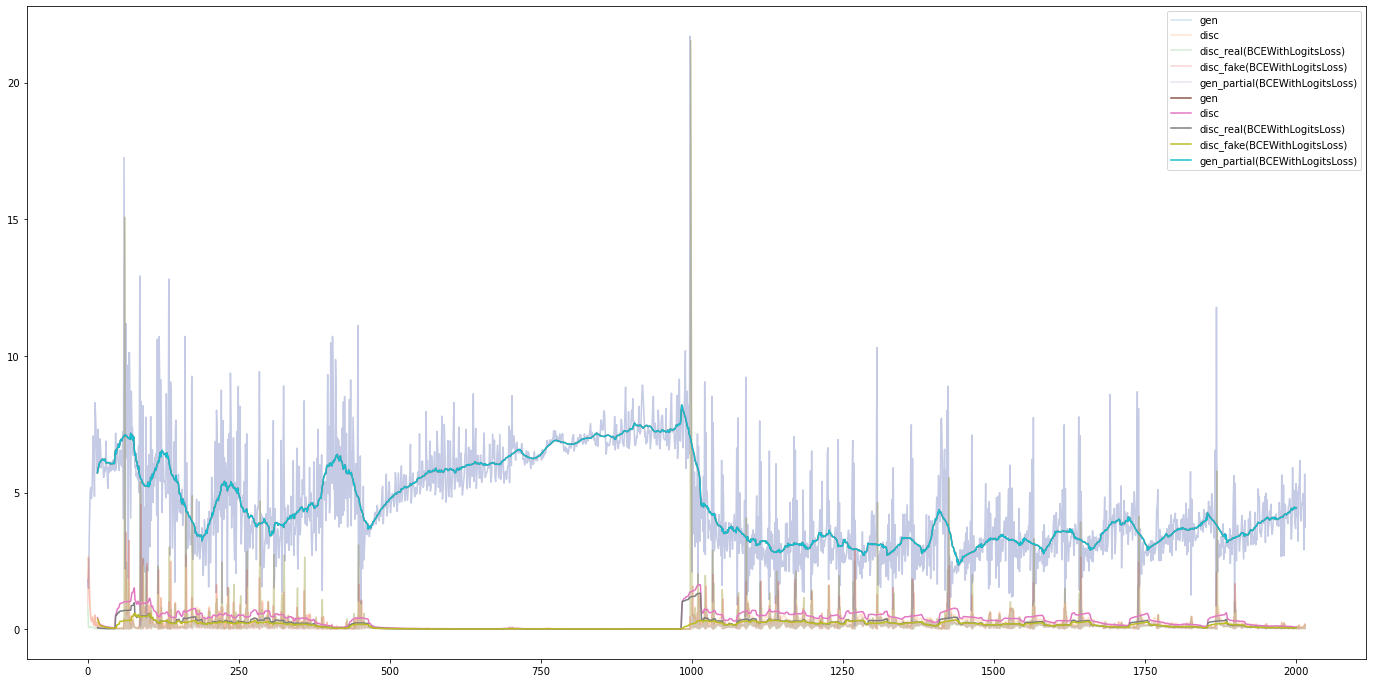

In [24]:
history = trainer.train(dataloader, num_epochs, output_dir, output_transform, True)

(-0.5, 992.5, 992.5, -0.5)

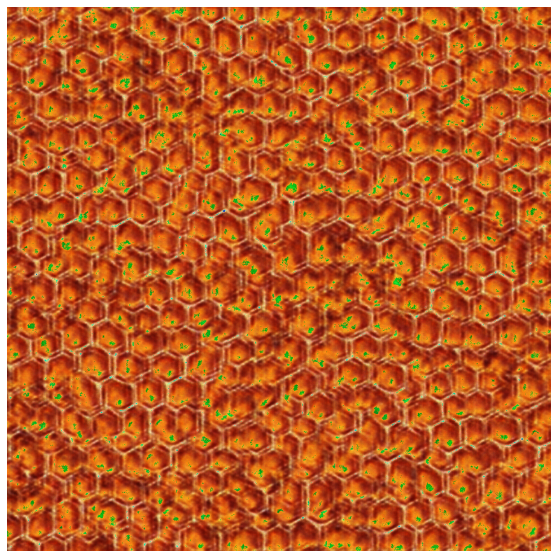

In [25]:
model['gen'].eval()
latent = torch.zeros(1, latent_channels[1], 32, 32, device=device)
with torch.no_grad():
    fake_image = output_transform(model['gen'](latent).cpu())
plt.imshow(fake_image)
plt.gcf().set_size_inches(10, 10)
plt.axis('off')

## WGAN-GP

In [26]:
model, optims = build_model(latent_channels, image_channels, hidden_layers, lr)
criterions = [loss.Wasserstein1()]
reg = [loss.GradPenalty(10)]
samplers = {
    'latent': lambda bs: torch.zeros(bs, latent_channels[1], *latent_spatial_shape),
    'labels': lambda bs: (
        torch.ones(bs, latent_channels[1], *latent_spatial_shape),
        (-1)*torch.ones(bs, latent_channels[1], *latent_spatial_shape)
    )
}
trainer = adversarial.Trainer(model, optims, samplers, criterions, device, reg)

num_epochs = 32
output_dir = os.path.join('../models/vanilla_psgan_hcomb_wgp')


epoch: 1; gen:  -8.794377; disc:   8.096478; disc_real(Wasserstein1):  -1.881762; disc_fake(Wasserstein1):   9.355150; disc_reg(GradPenalty):   0.623090; gen_partial(Wasserstein1):  -8.794377: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
epoch: 2; gen:  -6.426744; disc:   5.546741; disc_real(Wasserstein1):  -2.457849; disc_fake(Wasserstein1):   7.289955; disc_reg(GradPenalty):   0.714635; gen_partial(Wasserstein1):  -6.426744: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
epoch: 3; gen:  -5.453453; disc:   3.790605; disc_real(Wasserstein1):  -2.707444; disc_fake(Wasserstein1):   6.416652; disc_reg(GradPenalty):   0.081397; gen_partial(Wasserstein1):  -5.453453: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
epoch: 4; gen:  -4.041472; disc:   2.324918; disc_real(Wasserstein1):  -2.660650; disc_fake(Wasserstein1):   4.892762; disc_reg(GradPenalty):   0.092806; gen_partial(Wasserstein1):  -4.041472: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
epoch: 5; gen:  -2.042205; disc:   0

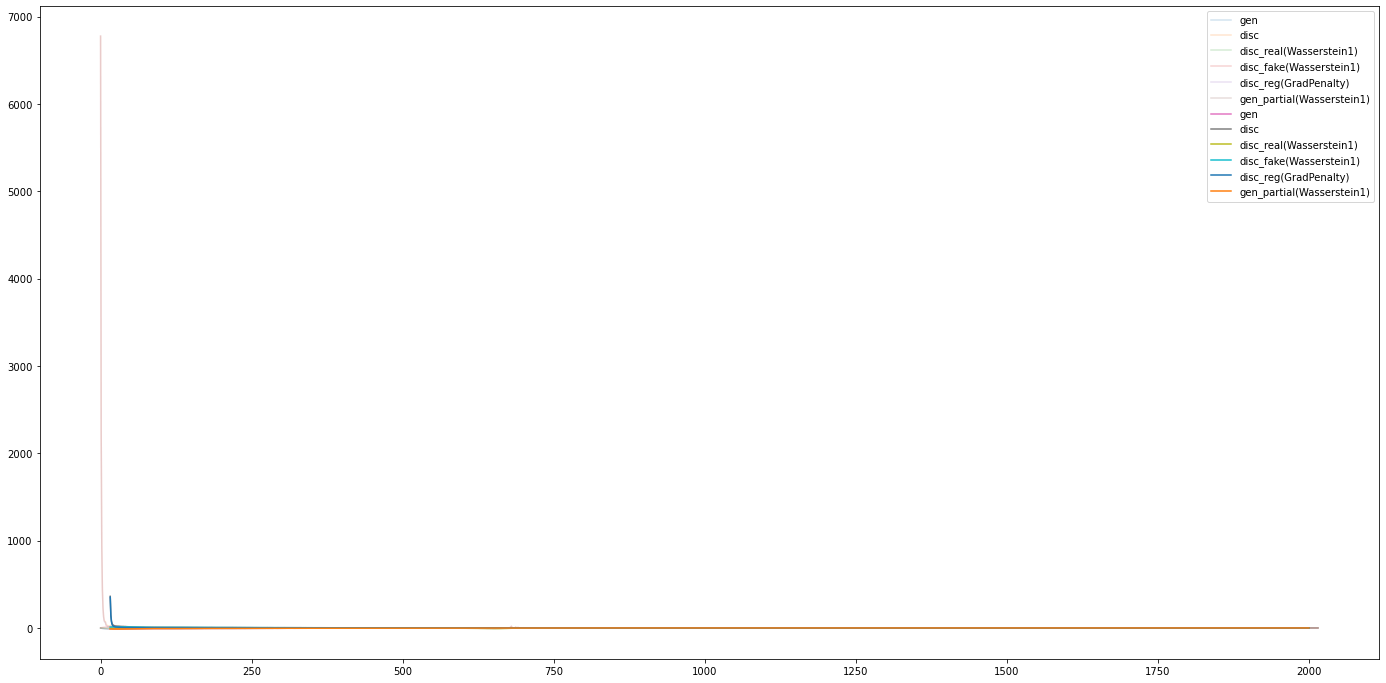

In [27]:
history = trainer.train(dataloader, num_epochs, output_dir, output_transform, True)

(-0.5, 992.5, 992.5, -0.5)

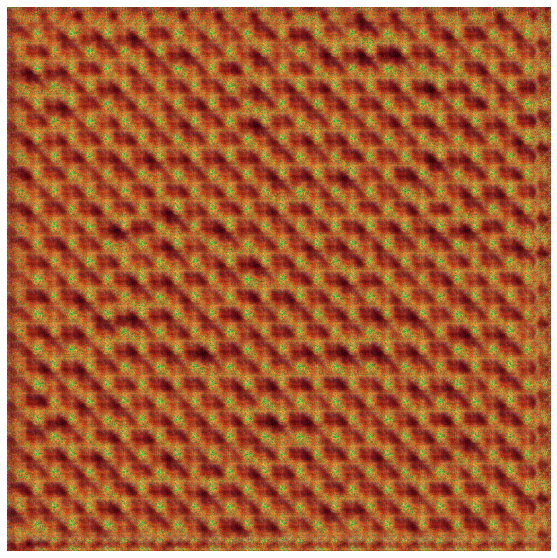

In [28]:
model['gen'].eval()
latent = torch.zeros(1, latent_channels[1], 32, 32, device=device)
with torch.no_grad():
    fake_image = output_transform(model['gen'](latent).cpu())
plt.imshow(fake_image)
plt.gcf().set_size_inches(10, 10)
plt.axis('off')


# DTD Single Class (Honeycombed)

In [ ]:
latent_channels = (40, 20, 4)
image_channels = 3
hidden_layers = 3
lr = 2e-4

In [ ]:
dataset_path = '../data/dtd'
model, _ = build_model(latent_channels, image_channels, hidden_layers, lr, False)

latent_spatial_shape = (5, 5)
crop_size = model['gen'](torch.zeros(1, latent_channels[1], *latent_spatial_shape, device=device)).shape[-2:]

batch_size=32
shuffle=True
num_workers=8
transform = tf.Compose([
    tf.RandomCrop(crop_size),
    tf.ToTensor(),
    tf.Normalize(0.5, 0.5)])
image_class = ('honeycombed',)

dataset = dtd.DescripableTextureDataset(dataset_path, transform, repeat=32)
dataset.chose_subset(image_class)

dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle, num_workers=num_workers)

samples = torch.split(next(iter(dataloader)), 1)

num_rows = int(np.ceil(batch_size//4))
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))
for sample, ax in zip(samples, axes.ravel()):
    sample = sample*0.5 + 0.5
    ax.imshow(sample.permute(0, 2, 3, 1).squeeze())
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()


## BCELoss

In [ ]:
model, optims = build_model(
    latent_channels, image_channels, hidden_layers, lr, False)
criterions = [nn.BCELoss(reduction='mean')]
samplers = {
    'latent': lambda bs: torch.rand(bs, latent_channels[1], *latent_spatial_shape)*2-1,
    'labels': lambda bs: (
        torch.zeros(bs, 1, *latent_spatial_shape),
        torch.ones(bs, 1, *latent_spatial_shape)
    )
}
trainer = adversarial.Trainer(device, criterions)

num_epochs = 48
output_dir = os.path.join('../models/vanilla_psgan_dtd_hcomb_bce')
output_transform = tf.Compose([
    tf.Lambda(lambda x: (x*0.5+0.5).squeeze().detach().cpu()),
    tf.ToPILImage('RGB')
])


In [ ]:
history = trainer.train(model, optims, dataloader, samplers,
                        num_epochs, output_dir, output_transform, True)

In [ ]:
model['gen'].eval()
latent = torch.rand(1, latent_channels[1], 32, 32, device=device)*2-1
fake_image = model['gen'](latent).detach().cpu().squeeze().permute(1, 2, 0)
fake_image = fake_image*0.5 + 0.5
plt.imshow(fake_image)
plt.gcf().set_size_inches(10, 10)
plt.axis('off')


## WGAN-GP

In [ ]:
model, optims = build_model(
    latent_channels, image_channels, hidden_layers, lr, True)
criterions = [loss.Wasserstein1(10)]
reg = [loss.GradPenalty()]
samplers = {
    'latent': lambda bs: torch.rand(bs, latent_channels[1], *latent_spatial_shape),
    'labels': lambda bs: (
        torch.ones(bs, 1, *latent_spatial_shape),
        (-1)*torch.ones(bs, 1, *latent_spatial_shape)
    )
}
trainer = adversarial.Trainer(device, criterions, reg)

num_epochs = 48
output_dir = os.path.join('../models/vanilla_psgan_hcomb_wgp')
output_transform = tf.Compose([
    tf.Lambda(lambda x: (x*0.5+0.5).squeeze().detach().cpu()),
    tf.ToPILImage('RGB')
])


In [ ]:
history = trainer.train(model, optims, dataloader, samplers,
                        num_epochs, output_dir, output_transform, True)

In [ ]:
model['gen'].eval()
latent = torch.rand(1, latent_channels[1], 32, 32, device=device)*2-1
fake_image = model['gen'](latent).detach().cpu().squeeze().permute(1, 2, 0)
fake_image = fake_image*0.5 + 0.5
plt.imshow(fake_image)
plt.gcf().set_size_inches(10, 10)
plt.axis('off')
